In [1]:
#https://www.kaggle.com/code/pcbreviglieri/predicting-smart-grid-stability-with-deep-learning/notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

In [2]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [3]:
sns.set()
start_time = datetime.now()

data = pd.read_csv('dataset/smart_grid_stability_augmented.csv')
print(data.head())
print(data.info())


       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 column

In [4]:
map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

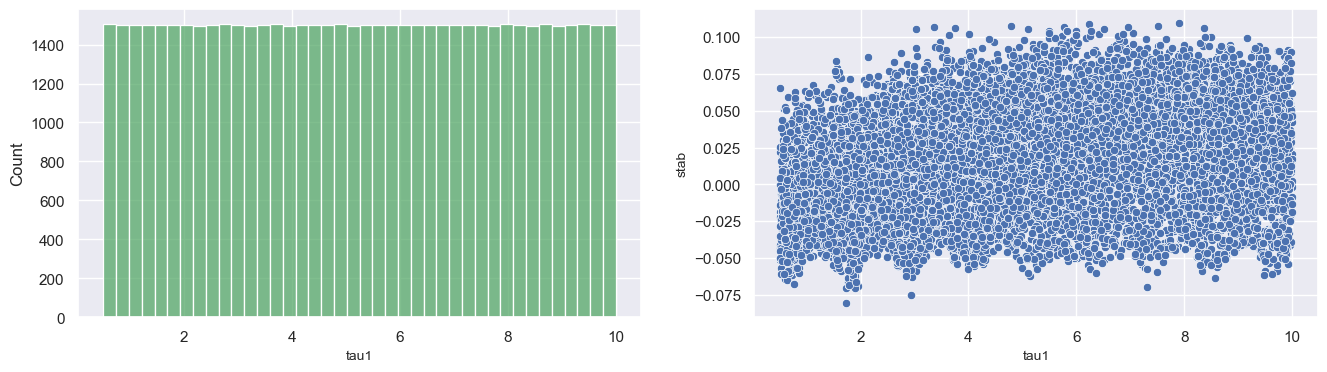

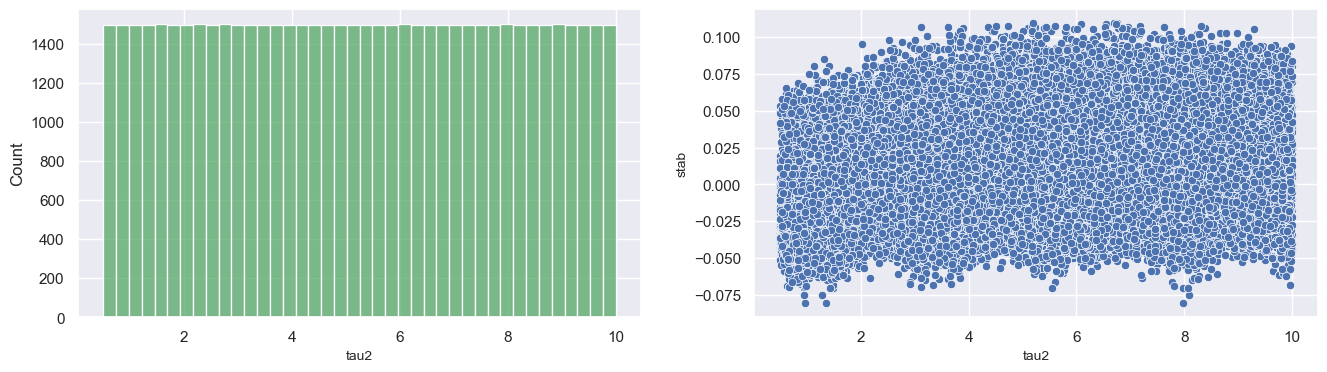

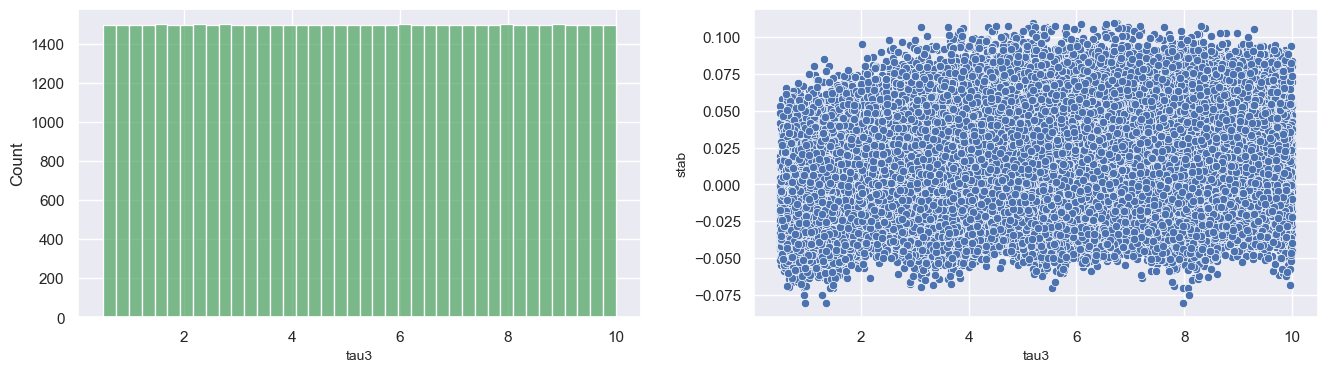

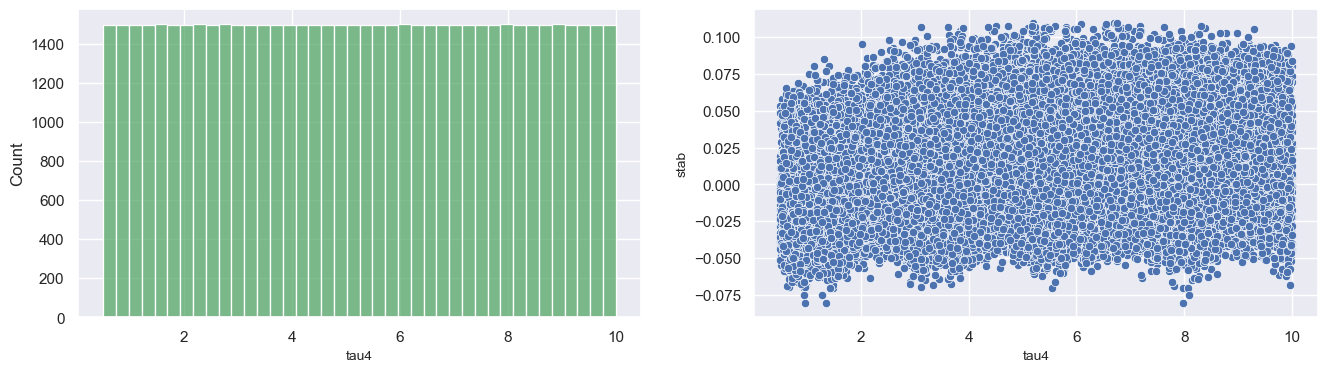

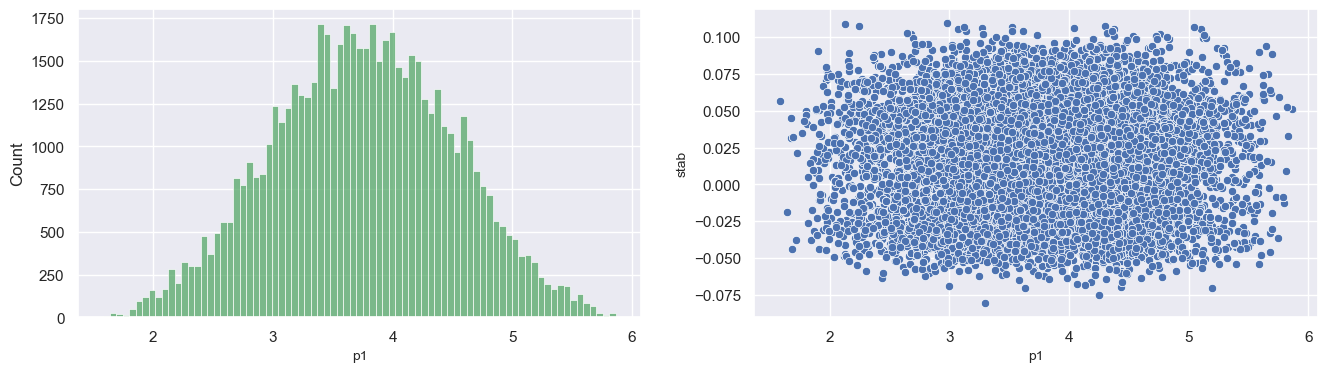

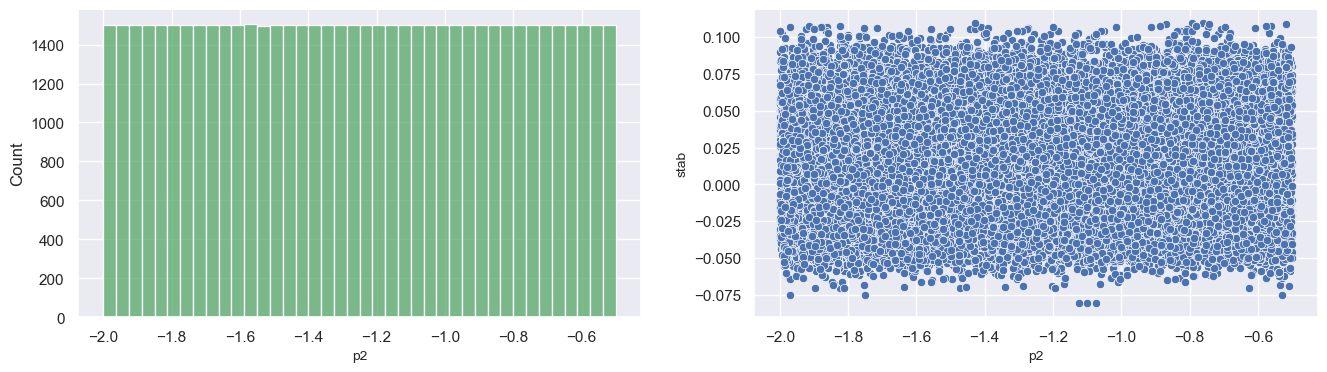

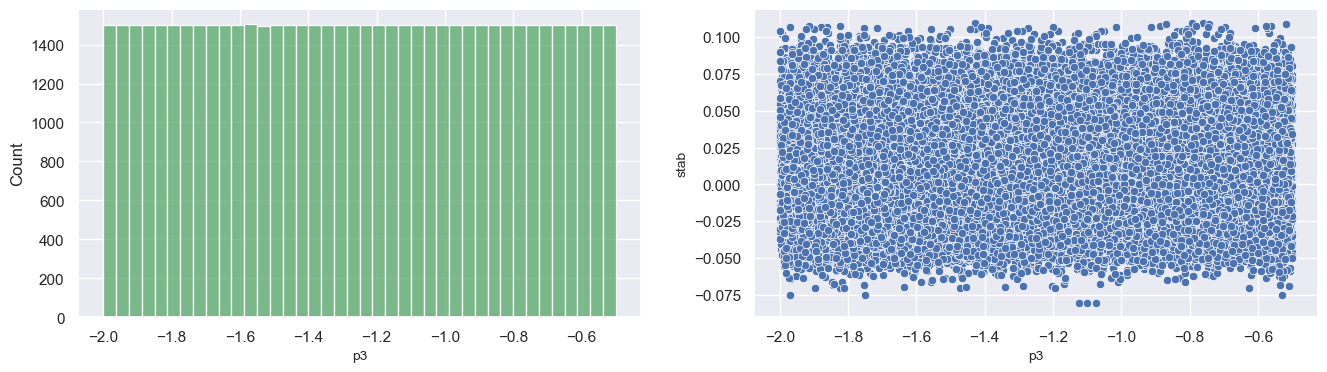

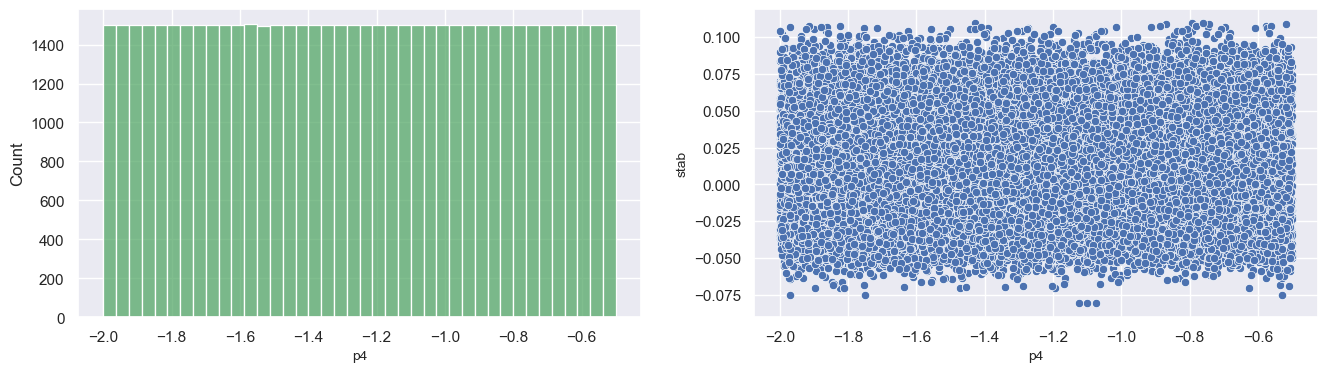

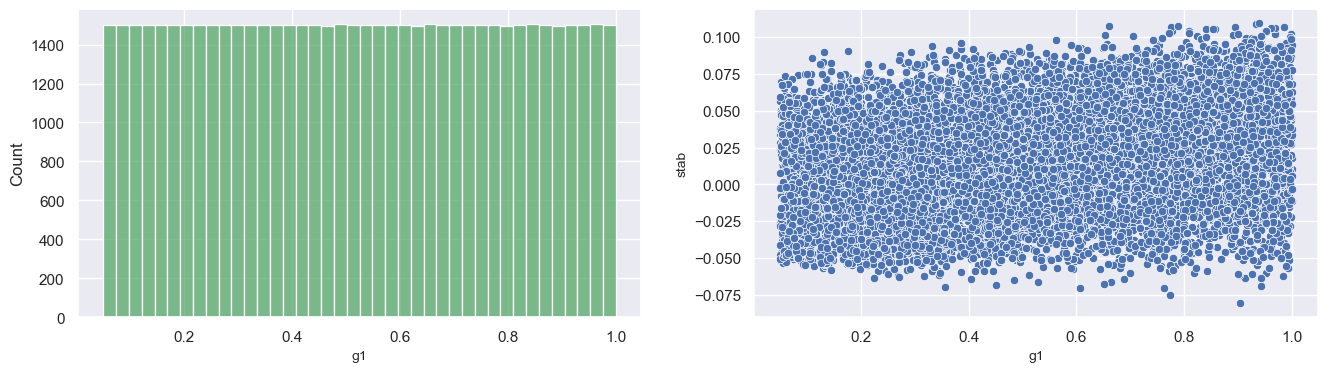

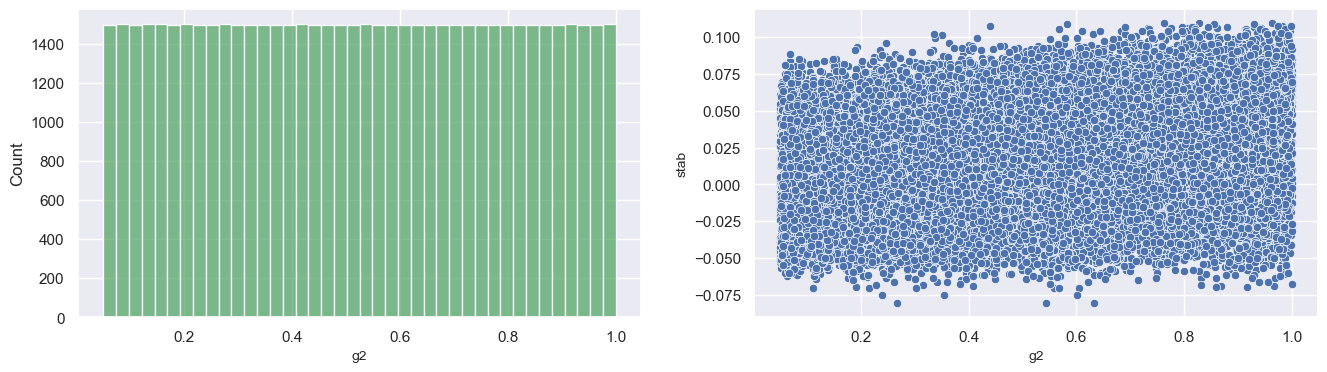

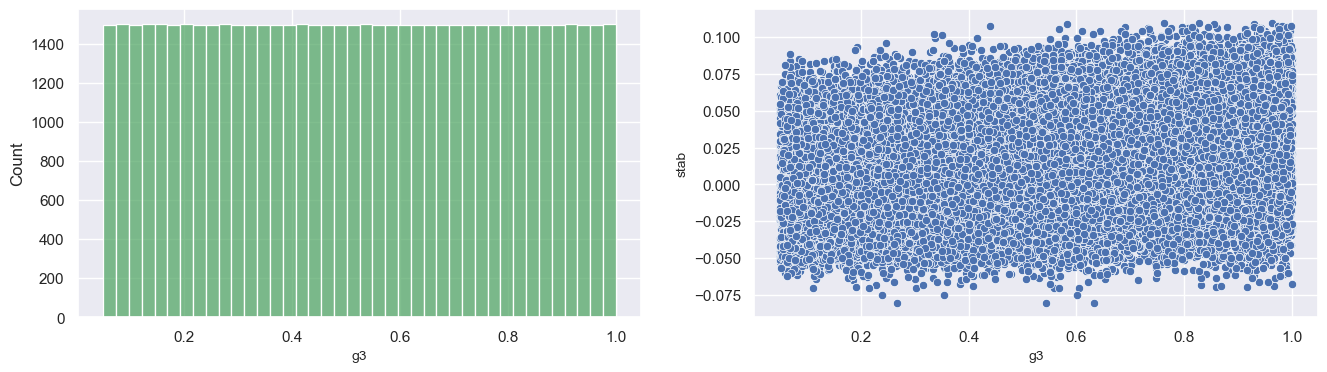

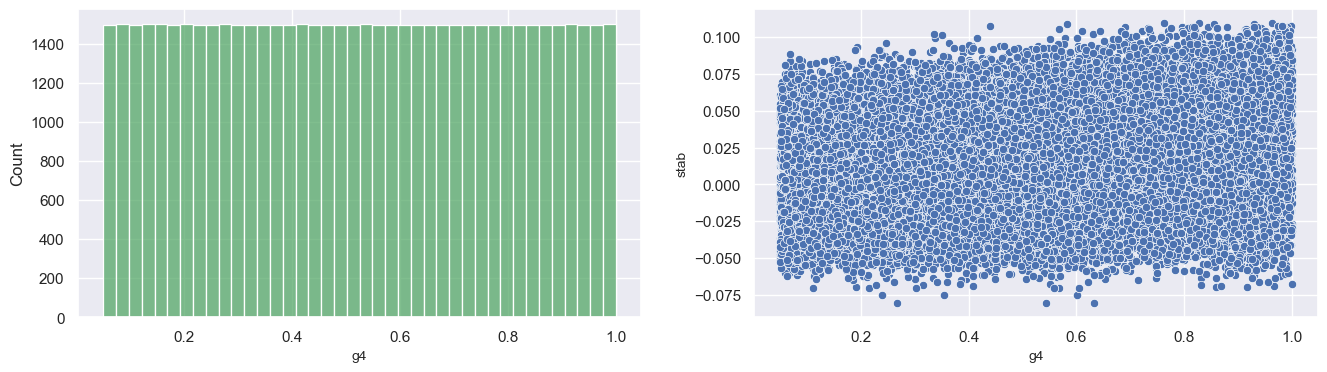

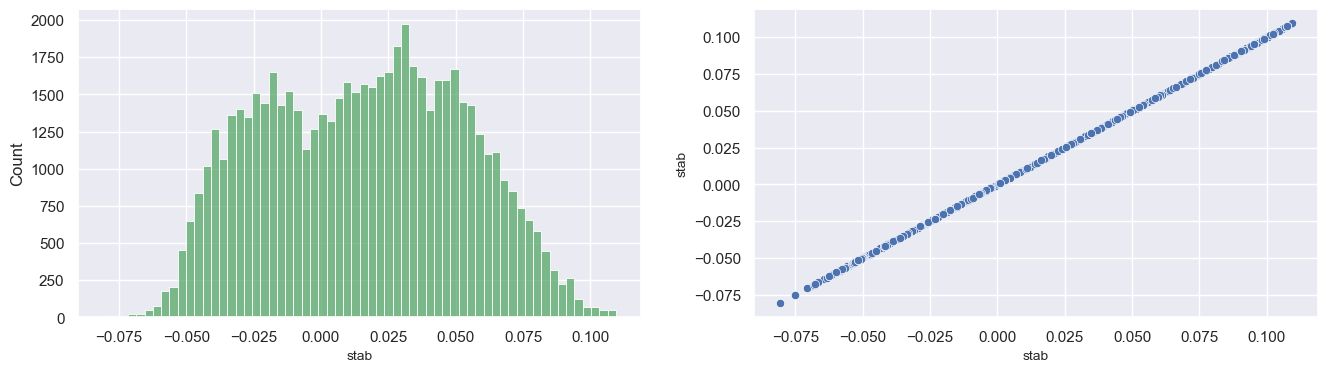

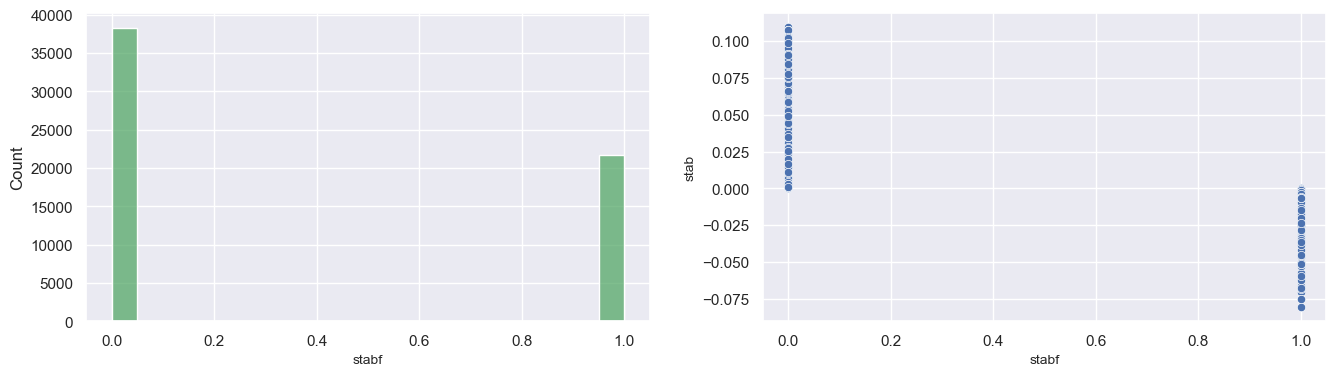

In [5]:
#the distribution of each feature and its relationship to stab

for column in data.columns:
    assessment(data, 'stab', column, -1)

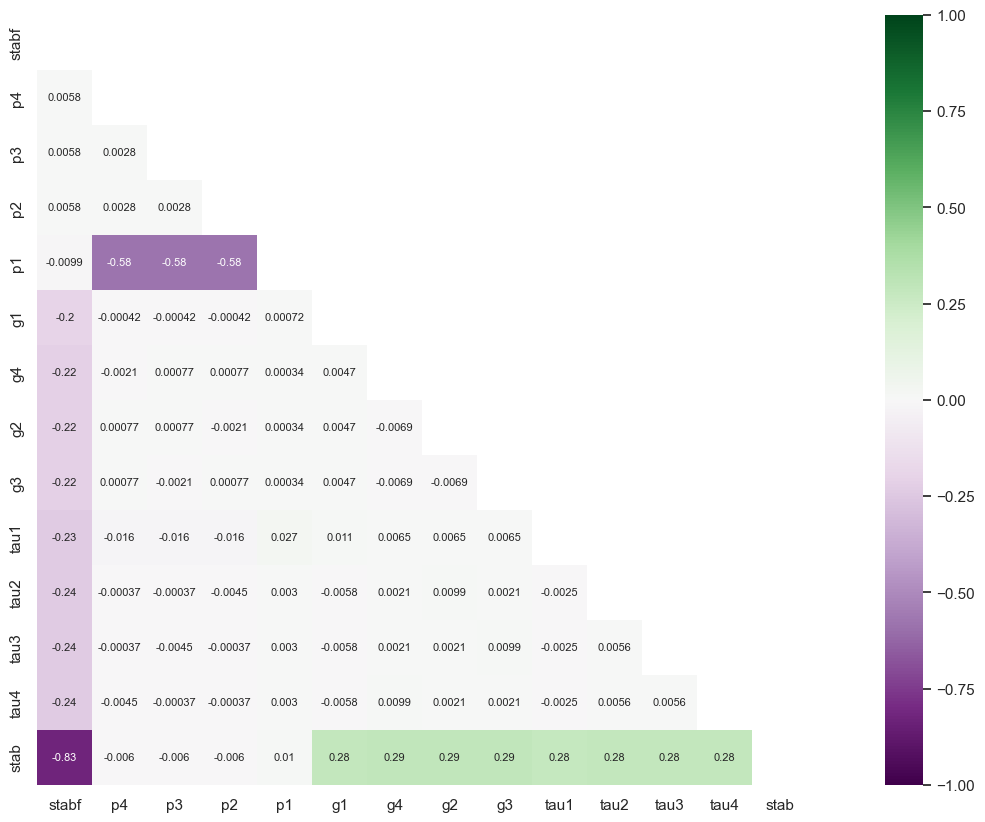

In [6]:
#correlation

correlation_map(data, 'stabf', 14)

In [7]:
#separate train, val and test dataset
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(0    0.63737
 1    0.36263
 Name: stabf, dtype: float64,
 0    0.643667
 1    0.356333
 Name: stabf, dtype: float64)

In [8]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

In [9]:
#feature scaling

scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

In [10]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

169/169 [==============================] - 0s 2ms/step - loss: 0.0921 - accuracy: 0.9607
Round 1 - Loss: 0.0921 | Accuracy: 96.07 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9724
Round 2 - Loss: 0.0646 | Accuracy: 97.24 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9793
Round 3 - Loss: 0.0543 | Accuracy: 97.93 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9815
Round 4 - Loss: 0.0460 | Accuracy: 98.15 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9807
Round 5 - Loss: 0.0471 | Accuracy: 98.07 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9857
Round 6 - Loss: 0.0369 | Accuracy: 98.57 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9850
Round 7 - Loss: 0.0352 | Accuracy: 98.50 %
169/169 [==============================] - 0s 2ms/step - l

In [12]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [13]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3801,61
Actual Stable,36,2102


In [14]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.38%


In [15]:
end_time = datetime.now()

print('\nStart time', start_time)
print('End time', end_time)
print('Time elapsed', end_time - start_time)


Start time 2023-11-16 20:35:40.171277
End time 2023-11-16 21:07:59.953838
Time elapsed 0:32:19.782561
